## Projekt SNUM
<ul>
 <li>Karolina Sztolcman 148394 </li>
  <li>Kacper Świderski 148110</li>
</ul>

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
from tensorflow.keras.datasets import cifar10  # Możesz również użyć innego zbioru danych
import cv2

Aby model mógł się dobrze nauczyć swojego zadania potrzeba było wielu przygotowanych danych do przetworzenia. Zamiast tworzyć je ręznie wykorzystaliśmy bibliotekę cifar10, która zawiera 60000 kolorowych obrazów o rozmiarze 32x32. <br>
Ładujemy je tworzymy czarno białe odpowiedniki 

In [6]:
# Ładowanie danych
(train_images, _), (test_images, _) = cifar10.load_data()

train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

# Przygotowanie danych
train_images_gray = tf.image.rgb_to_grayscale(train_images).numpy()
test_images_gray = tf.image.rgb_to_grayscale(test_images).numpy()


Funkcja autoencoder definiuje model autoenkodera, który składa się z dwóch głównych części: encoder'a i decoder'a. Celem autoenkodera jest kompresja i dekompresja danych, a model jest trenowany w taki sposób, aby odtwarzał dane wejściowe. Poniżej opisano strukturę obu części modelu:

#### Encoder:
<ul>
  <li>Pierwsza warstwa konwolucyjna (Conv2D) z 32 filtrami o rozmiarze 3x3 i funkcją aktywacji ReLU. </li>
  <li>Warstwa poolingowa (MaxPooling2D) o rozmiarze 2x2, służąca do zmniejszenia rozmiaru przestrzennego.</li>
  <li>Druga warstwa konwolucyjna z 64 filtrami o rozmiarze 3x3 i funkcją aktywacji ReLU. </li>
  <li>Druga warstwa poolingowa o rozmiarze 2x2.</li>
</ul>

#### Decoder:
<ul>
  <li>Trzecia warstwa konwolucyjna (Conv2DTranspose) z 64 filtrami o rozmiarze 3x3 i funkcją aktywacji ReLU.  </li>
  <li>Warstwa upsamplingu (UpSampling2D) o rozmiarze 2x2, służąca do zwiększenia rozmiaru przestrzennego.</li>
  <li>Kolejna warstwa upsamplingu o rozmiarze 2x2.</li>
  <li>Czwarta warstwa konwolucyjna (Conv2DTranspose) z 32filtrami o rozmiarze 3x3 i funkcją aktywacji ReLU. </li>
  <li>Ostatnia warstwa konwolucyjna (Conv2D) z 3 filtrami (odpowiadającymi kanałom RGB) o rozmiarze 3x3 i funkcją aktywacji sigmoid, co pozwala na generowanie wartości w zakresie [0, 1].</li>
</ul>

In [7]:
# Model Autoenkodera
def autoencoder(input_shape):
    model = models.Sequential()

    # Koder
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    #model.add(layers.BatchNormalization(momentum=0.2))
    #model.add(layers.Dropout(0.2))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    #model.add(layers.BatchNormalization(momentum=0.2))
    # model.add(layers.Dropout(0.2))


    # Dekoder
    model.add(layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.UpSampling2D((2, 2)))
    model.add(layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.UpSampling2D((2, 2)))
    model.add(layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same'))

    return model

In [8]:
from keras import optimizers
# Konfiguracja modelu
input_shape = train_images_gray.shape[1:]
autoencoder = autoencoder(input_shape)
optimizer = optimizers.Adam(weight_decay=0.002)
autoencoder.compile(optimizer=optimizer, loss='mse')

# Trenowanie modelu
errorFunction = autoencoder.fit(train_images_gray, train_images, epochs=10, batch_size=128, shuffle=True, validation_data=(test_images_gray, test_images))

# Kolorowanie przez model
decoded_images = autoencoder.predict(test_images_gray)




Epoch 1/10

391/391 [==============================] - 23s 56ms/step - loss: 0.0154 - val_loss: 0.0109
Epoch 2/10
391/391 [==============================] - 20s 52ms/step - loss: 0.0103 - val_loss: 0.0096
Epoch 3/10
391/391 [==============================] - 21s 54ms/step - loss: 0.0094 - val_loss: 0.0092
Epoch 4/10
391/391 [==============================] - 21s 54ms/step - loss: 0.0090 - val_loss: 0.0088
Epoch 5/10
391/391 [==============================] - 20s 50ms/step - loss: 0.0087 - val_loss: 0.0086
Epoch 6/10
391/391 [==============================] - 21s 53ms/step - loss: 0.0086 - val_loss: 0.0083
Epoch 7/10
391/391 [==============================] - 20s 52ms/step - loss: 0.0083 - val_loss: 0.0081
Epoch 8/10
391/391 [==============================] - 21s 52ms/step - loss: 0.0082 - val_loss: 0.0080
Epoch 9/10
391/391 [==============================] - 21s 53ms/step - loss: 0.0080 - val_loss: 0.0079
Epoch 10/10
313/313 [==============================] - 1s 4ms/step


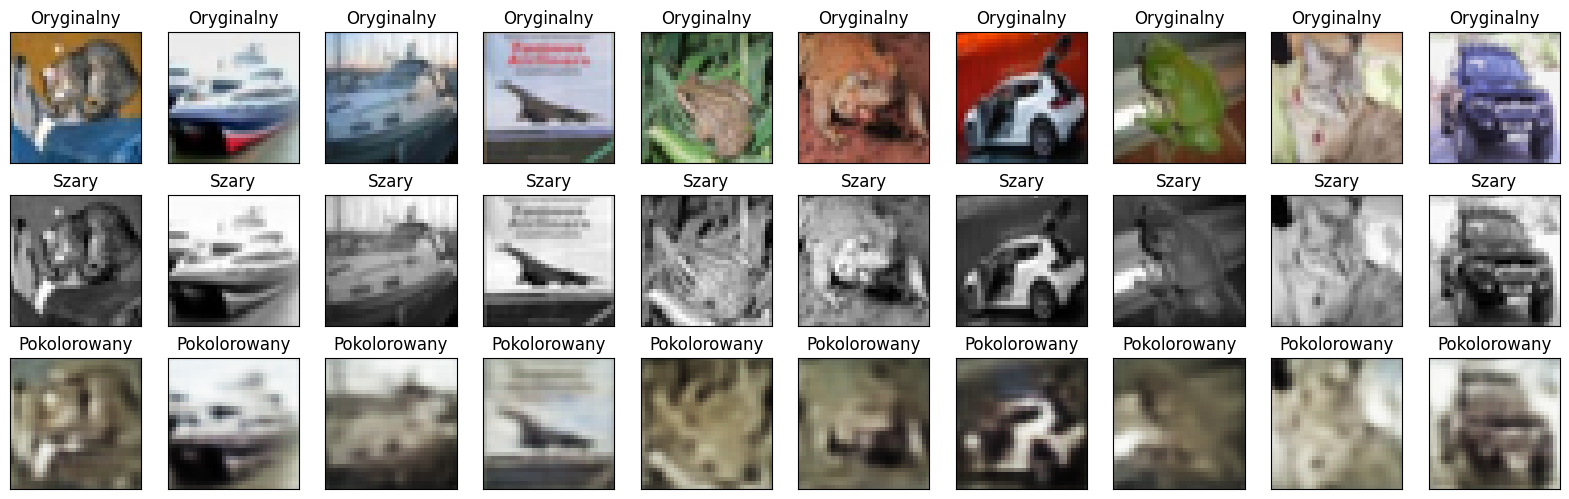

In [9]:
import matplotlib.pyplot as plt

n = 10  # liczba przykładów do wyświetlenia
plt.figure(figsize=(20, 6))

for i in range(n):
    # Oryginalny obraz
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(test_images[i])
    plt.title("Oryginalny")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Obraz w skali szarości przed dekodowaniem
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(test_images_gray[i][:, :, 0], cmap='gray')
    plt.title("Szary")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Zdekodowany obraz
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(decoded_images[i])
    plt.title("Pokolorowany")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [10]:
def showErrorFunction():
    plt.title('Strata modelu w trakcie epok treningu')
    plt.xlabel('Epoka')
    plt.ylabel('Strata')
    plt.plot(errorFunction.history['loss'], label='Strata treningowa')
    plt.plot(errorFunction.history['val_loss'], label='Strata walidacyjna')
    plt.xticks(np.arange(0, len(errorFunction.history['loss']), 1), np.arange(1, len(errorFunction.history['loss'])+1, 1))
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()

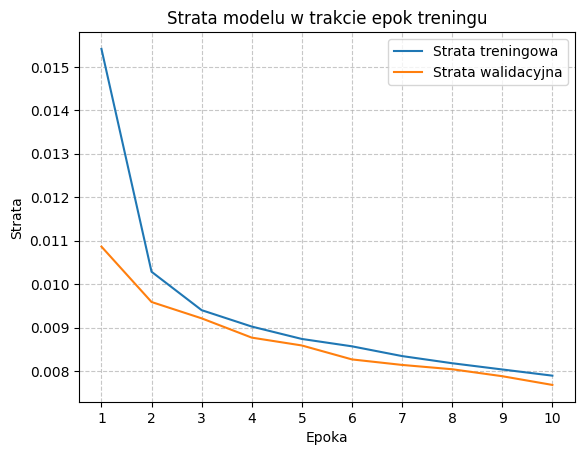

In [11]:
showErrorFunction()

#### Wnioski

Po przetwarzaniu trwającego 10 epok możemy zauważyć znaczne wypłaszczenie. TODO

#### Funkcja do kolorowania obrazów o dowolnym rozmiarze

In [31]:
import cv2 as cv

def plot_disk_image(model, path, original_images, gray_images):
    # Wczytywanie obrazu z dysku
    y = cv.cvtColor(cv.imread(path), cv.COLOR_BGR2RGB).astype('float32') / 255
    x = cv.cvtColor(y, cv.COLOR_RGB2GRAY)

    # Przygotuj dane
    x = x.reshape(1, x.shape[0], x.shape[1], 1)
    Y = model.predict(x)[0]

    # Wyświetlanie wynikiów
    plt.figure(figsize=(8, 4))

    # Oryginalny obraz
    plt.subplot(1, 3, 1)
    plt.imshow(y)
    plt.title("Oryginalny")
    plt.gray()
    plt.axis('off')

    # Obraz w skali szarości 
    plt.subplot(1, 3, 2)
    plt.imshow(x[0, :, :, 0], cmap='gray')
    plt.title("Szary")
    plt.gray()
    plt.axis('off')

    # Pokolorowany obraz
    plt.subplot(1, 3, 3)
    plt.imshow(Y)
    plt.title("Pokolorowany")
    plt.gray()
    plt.axis('off')

    plt.show()

1/1 [==============================] - 0s 159ms/step


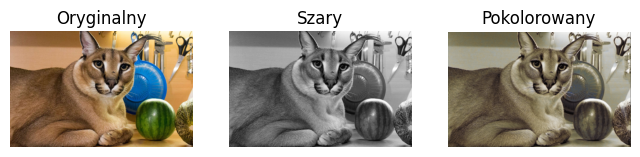

In [32]:
plot_disk_image(autoencoder, 'test.jpg', test_images, test_images_gray)